# Extract channel map from raw file

In [1]:
# Import library
import numpy as np
import pandas as pd
from xml.etree import ElementTree
import matplotlib.pyplot as plt
import re
import os

from probeinterface import Probe, ProbeGroup, write_prb
from probeinterface.plotting import plot_probe, plot_probe_group


In [27]:
# local_path = 'E:/Dataset/KQTY/GridBat/32622/flight_room/231006/ephys/20231006_152611.rec/20231006_152611_merged.trodesconf'

In [35]:
# local_path = 'C:/Users/Tatsumi/Documents/Data/KQTY_NP/32623/20230907_1min'

In [3]:
local_path = 'Z:/users/Tatsumi/data/NP_Kevin/GridBat/32622/flight_room/231007/split_1min/20231007_133453_merged_1min.trodesconf'
local_path

'Z:/users/Tatsumi/data/NP_Kevin/GridBat/32622/flight_room/231007/split_1min/20231007_133453_merged_1min.trodesconf'

In [4]:
header_size = None
with open(local_path, mode='rb') as f:
    while True:
        line = f.readline()
        if b"</Configuration>" in line:
            header_size = f.tell()
            break
    if header_size is None:
        ValueError("SpikeGadgets: the xml header does not contain '</Configuration>'")

    f.seek(0)
    header_txt = f.read(header_size).decode('utf8')

In [5]:
# explore xml header
root = ElementTree.fromstring(header_txt)
# gconf = sr = root.find('GlobalConfiguration')
hconf = root.find('HardwareConfiguration')
sconf = root.find('SpikeConfiguration')

In [6]:
# Number of channels for each probe
sources = hconf.findall("SourceOptions")
num_probe = len(sources)
num_chans = np.zeros((num_probe))
for pr in range(num_probe):
    source = sources[pr]
    source_id = source.attrib['name']
    options = source.findall("CustomOption")
    for option in options:
        if option.attrib['name'] == 'channelsOn':
            probe_map = option.attrib['data']
            probe_map = [int(ch) for ch in probe_map.split()]
            num_chans[pr] = sum(probe_map)
print(num_chans)

[192. 192.]


In [7]:
# Get channel info
# chan_map = np.zeros((int(sum(num_chans)),5))
chan_map = []
for trode in sconf:
    for schan in trode:
        pr = int(schan.attrib['spikeSortingGroup'])
        id = int(trode.attrib['id']) - 1000*(pr+1) 
        hwchan = int(schan.attrib['hwChan'])
        x = int(schan.attrib['coord_ml'])
        y = int(schan.attrib['coord_dv'])
        ap = int(schan.attrib['coord_ap'])

        # chan_map.append((x,y,pr,id,hwchan))
        chan_map.append((x,y,pr,id,hwchan))

chan_map = np.asarray(chan_map)
chan_map = pd.DataFrame(chan_map,columns=['x','y','probe','id','hwChan'])
print(chan_map)

      x     y  probe   id  hwChan
0    -8  3600      0  352     477
1    24  3600      0  351     476
2   -24  3580      0  350     413
3     8  3580      0  349     412
4    -8  3560      0  348     349
..   ..   ...    ...  ...     ...
379   8  1980      1  189     686
380  -8  1960      1  188     623
381  24  1960      1  187     622
382 -24  1940      1  186     559
383   8  1940      1  185     558

[384 rows x 5 columns]


In [18]:
device_indices = [i for i in range(len(chan_map))]
chan_map_new = chan_map
chan_map_new['id_new'] = device_indices

In [16]:
chan_map_new = []
start_id = 0
for pr in range(num_probe):
    chan_map_old = chan_map[chan_map['probe']==pr]
    chan_map_new_pr = chan_map_old.sort_values('id')
    chan_id_new = [i for i in range(start_id,start_id + len(chan_map_old))]
    start_id = np.max(chan_id_new) + 1
    chan_map_new_pr['id_new'] = chan_id_new

    chan_map_new.append(chan_map_new_pr)

In [25]:
chan_map_new[chan_map_new['probe']==0].to_numpy()

array([[  -8, 3600,    0,  352,  477,    0],
       [  24, 3600,    0,  351,  476,    1],
       [ -24, 3580,    0,  350,  413,    2],
       ...,
       [  24, 1720,    0,  163,  588,  189],
       [ -24, 1700,    0,  162,  525,  190],
       [   8, 1700,    0,  161,  524,  191]], dtype=int64)

In [20]:
# Generate NP probes
probes = []
for pr in range(num_probe):
    positions = chan_map[chan_map['probe']==pr][['x','y']]
    shank_ids = np.ones(int(num_chans[pr])) * pr
    probe = Probe(ndim=2, si_units='um')
    probe.set_contacts(positions=positions, shapes='circle', shape_params={'radius': 5},shank_ids=shank_ids)
    probe.set_contact_ids(contact_ids=contact_ids)
    probes.append(probe)
print(probes)

NameError: name 'contact_ids' is not defined

In [76]:
probes[0].device_channel_indices

array([351, 350, 349, 348, 347, 346, 345, 344, 343, 342, 341, 340, 339,
       338, 337, 336, 335, 334, 333, 332, 331, 330, 329, 328, 327, 326,
       325, 324, 323, 322, 321, 320, 319, 318, 317, 316, 315, 314, 313,
       312, 311, 310, 309, 308, 307, 306, 305, 304, 303, 302, 301, 300,
       299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287,
       286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274,
       273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261,
       260, 259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 249, 248,
       247, 246, 245, 244, 243, 242, 241, 240, 239, 238, 237, 236, 235,
       234, 233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222,
       221, 220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209,
       208, 207, 206, 205, 204, 203, 202, 201, 200, 199, 198, 197, 196,
       195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183,
       182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 17

In [73]:
probes[0].contact_ids

array(['1335', '1334', '1333', '1332', '1331', '1330', '1329', '1328',
       '1327', '1326', '1325', '1324', '1323', '1322', '1321', '1320',
       '1319', '1318', '1317', '1316', '1315', '1314', '1313', '1312',
       '1311', '1310', '1309', '1308', '1307', '1306', '1305', '1304',
       '1303', '1302', '1301', '1300', '1299', '1298', '1297', '1296',
       '1295', '1294', '1293', '1292', '1291', '1290', '1289', '1288',
       '1287', '1286', '1285', '1284', '1283', '1282', '1281', '1280',
       '1279', '1278', '1277', '1276', '1275', '1274', '1273', '1272',
       '1271', '1270', '1269', '1268', '1267', '1266', '1265', '1264',
       '1263', '1262', '1261', '1260', '1259', '1258', '1257', '1256',
       '1255', '1254', '1253', '1252', '1251', '1250', '1249', '1248',
       '1247', '1246', '1245', '1244', '1243', '1242', '1241', '1240',
       '1239', '1238', '1237', '1236', '1235', '1234', '1233', '1232',
       '1231', '1230', '1229', '1228', '1227', '1226', '1225', '1224',
      

In [17]:
print(probes[0].device_channel_indices)

None


In [18]:
df = probes[0].to_dataframe()
df

,x,y,contact_shapes,radius,shank_ids,contact_ids
0,-8.0,3600.0,circle,5.0,0.0,
1,24.0,3600.0,circle,5.0,0.0,
2,-24.0,3580.0,circle,5.0,0.0,
3,8.0,3580.0,circle,5.0,0.0,
4,-8.0,3560.0,circle,5.0,0.0,
...,...,...,...,...,...,...
187,8.0,1740.0,circle,5.0,0.0,
188,-8.0,1720.0,circle,5.0,0.0,
189,24.0,1720.0,circle,5.0,0.0,
190,-24.0,1700.0,circle,5.0,0.0,


In [19]:
# Generate probe groups
probegroup = ProbeGroup()
for probe in probes:
    probegroup.add_probe(probe)
print('probegroup.get_channel_count()', probegroup.get_channel_count())

probegroup.get_channel_count() 384


In [75]:
for pr in range(num_probe):
    contact_ids = chan_map[chan_map['probe']==pr]['id'].to_numpy() + 960 * pr
    # print(contact_ids)
    # print(type(contact_ids))
    probes[pr].set_device_channel_indices(contact_ids)
print(probegroup.get_global_device_channel_indices())

[(0,  351) (0,  350) (0,  349) (0,  348) (0,  347) (0,  346) (0,  345)
 (0,  344) (0,  343) (0,  342) (0,  341) (0,  340) (0,  339) (0,  338)
 (0,  337) (0,  336) (0,  335) (0,  334) (0,  333) (0,  332) (0,  331)
 (0,  330) (0,  329) (0,  328) (0,  327) (0,  326) (0,  325) (0,  324)
 (0,  323) (0,  322) (0,  321) (0,  320) (0,  319) (0,  318) (0,  317)
 (0,  316) (0,  315) (0,  314) (0,  313) (0,  312) (0,  311) (0,  310)
 (0,  309) (0,  308) (0,  307) (0,  306) (0,  305) (0,  304) (0,  303)
 (0,  302) (0,  301) (0,  300) (0,  299) (0,  298) (0,  297) (0,  296)
 (0,  295) (0,  294) (0,  293) (0,  292) (0,  291) (0,  290) (0,  289)
 (0,  288) (0,  287) (0,  286) (0,  285) (0,  284) (0,  283) (0,  282)
 (0,  281) (0,  280) (0,  279) (0,  278) (0,  277) (0,  276) (0,  275)
 (0,  274) (0,  273) (0,  272) (0,  271) (0,  270) (0,  269) (0,  268)
 (0,  267) (0,  266) (0,  265) (0,  264) (0,  263) (0,  262) (0,  261)
 (0,  260) (0,  259) (0,  258) (0,  257) (0,  256) (0,  255) (0,  254)
 (0,  

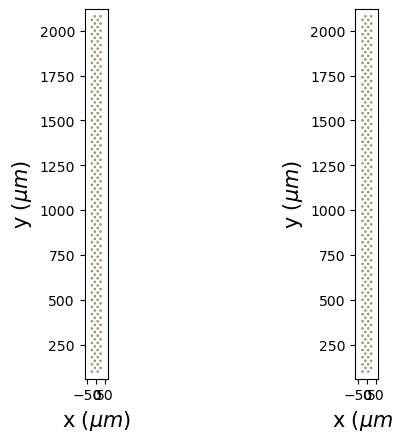

In [12]:
plot_probe_group(probegroup, same_axes=False, with_channel_index=False)
plt.show()

In [14]:
path_split = local_path.split('\\')
path_split = path_split[-2].split('.')
# output_path = os.path.dirname(local_path) + '\\' + path_split[0] + '.prb'
output_path = path_split[0] + '.prb'
print(output_path)

# save to probe file
write_prb(file=output_path,probegroup=probegroup)

20230907_161730.prb
